In [2]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np

import tensorflow as tf

In [3]:
# Download the dataset
!wget ftp://ftp.nersc.no/pub/ml_course/amsr2_201501311200.npz

--2021-11-03 07:23:40--  ftp://ftp.nersc.no/pub/ml_course/amsr2_201501311200.npz
           => ‘amsr2_201501311200.npz’
Resolving ftp.nersc.no (ftp.nersc.no)... 158.37.60.245
Connecting to ftp.nersc.no (ftp.nersc.no)|158.37.60.245|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/ml_course ... done.
==> SIZE amsr2_201501311200.npz ... 4523592
==> PASV ... done.    ==> RETR amsr2_201501311200.npz ... done.
Length: 4523592 (4.3M) (unauthoritative)

amsr2_201501311200. 100%[===================>]   4.31M  1.62MB/s    in 2.7s    

2021-11-03 07:23:44 (1.62 MB/s) - ‘amsr2_201501311200.npz’ saved [4523592]



In [4]:
# load data into dictionary
full_dataset = dict(**np.load('amsr2_201501311200.npz'))
# names of bands in the dictionary:
print(full_dataset.keys())
# size of 2D arrays
print(full_dataset['h06'].shape, full_dataset['sit'].shape)

dict_keys(['h06', 'v06', 'h07', 'v07', 'h10', 'v10', 'h18', 'v18', 'h23', 'v23', 'h36', 'v36', 'h89', 'v89', 'sit'])
(200, 200) (200, 200)


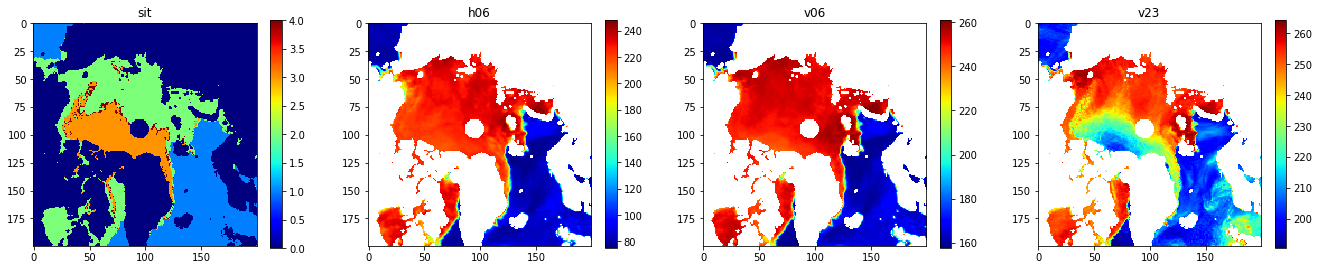

In [5]:
def plot_bands(dataset, band_names):
    '''Plot bands from the dataset'''
    fig, ax = plt.subplots(1, len(band_names), figsize=(23, 7))
    for i, b in enumerate(bands2plot):
        img = ax[i].imshow(dataset[b], cmap='jet', interpolation='nearest')
        plt.colorbar(img, ax=ax[i], shrink=0.6)
        ax[i].set_title(b)    

# select random bands to show maps:
bands2plot = [
    'sit',  # sea ice type
    'h06',  # Brightness temperature at 6  GHz at horizontal polarization
    'v06',  # Brightness temperature at 6  GHz at vertical polarization
    'v23'   # Brightness temperature at 6  GHz at vertical polarization
]
 
# plot maps of selected bands
plot_bands(full_dataset, bands2plot)

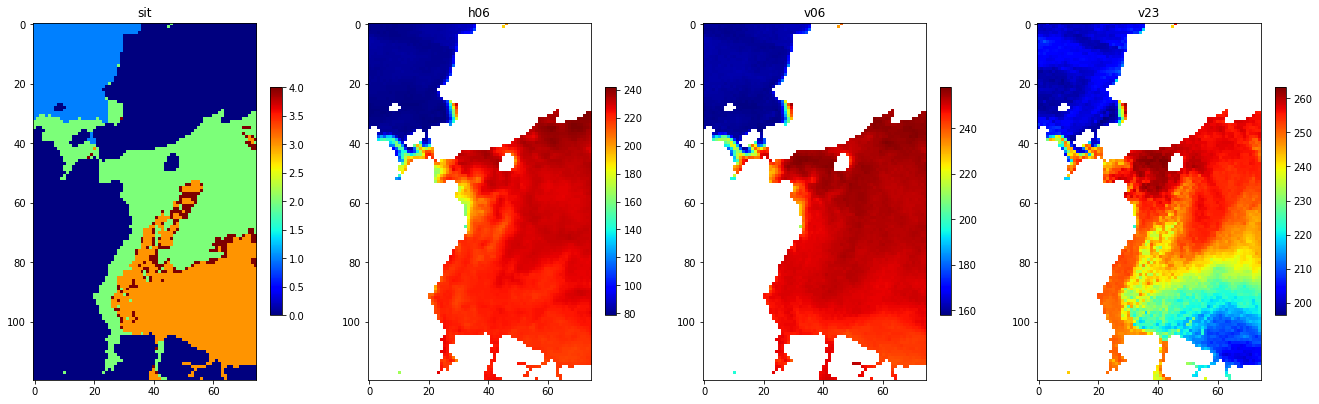

In [6]:
# Select a region for the model trainingdevelopment
dev_subset = {key:value[0:120, 0:75] for key, value in full_dataset.items()}
# Display the selected region
plot_bands(dev_subset, bands2plot)

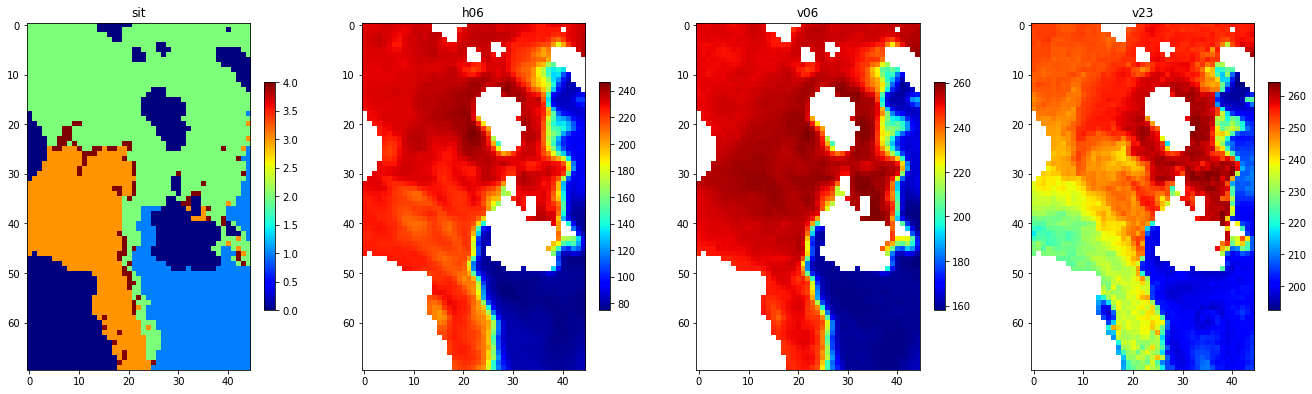

In [11]:
# Selct a validation region
val_subset = {key:value[70:140, 100:145] for key, value in full_dataset.items()}
# Display the selected region
plot_bands(val_subset, bands2plot)

In [9]:
def mask_data(dataset):
    # Create a 2D mask of valid pixels
    mask = (dataset['sit'] > 0) * (dataset['sit'] < 4)
    # 1D vectors of SIT and AMSR2 measurements at the selectef bands
    masked_dataset = {key:value[mask] for key, value in dataset.items()}
    return mask, masked_dataset

# Mask/transform the dev subset
mask_dev, masked_dev_subset = mask_data(dev_subset)
# Mask/transform the val subset
mask_val, masked_val_subset = mask_data(val_subset)

Text(0, 0.5, 'v23')

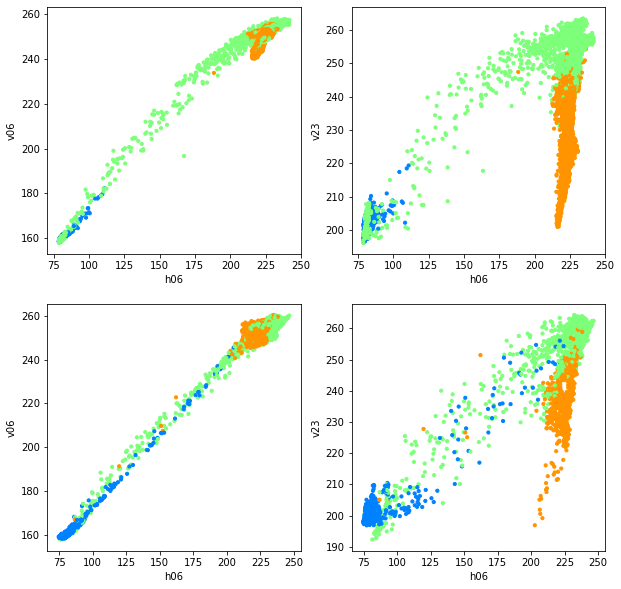

In [10]:
# Scatterplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
ax1.scatter(masked_dev_subset['h06'], masked_dev_subset['v06'], 10, masked_dev_subset['sit'], cmap='jet', vmin=0, vmax=4)
ax1.set_xlabel('h06'); ax1.set_ylabel('v06')
ax2.scatter(masked_dev_subset['h06'], masked_dev_subset['v23'], 10, masked_dev_subset['sit'], cmap='jet', vmin=0, vmax=4)
ax2.set_xlabel('h06'); ax2.set_ylabel('v23')
ax3.scatter(masked_val_subset['h06'], masked_val_subset['v06'], 10, masked_val_subset['sit'], cmap='jet', vmin=0, vmax=4)
ax3.set_xlabel('h06'); ax3.set_ylabel('v06')
ax4.scatter(masked_val_subset['h06'], masked_val_subset['v23'], 10, masked_val_subset['sit'], cmap='jet', vmin=0, vmax=4)
ax4.set_xlabel('h06'); ax4.set_ylabel('v23')

## Build a model 

In [13]:
# set bands that are used as features
bands = ['h06', 'v06', 'h07', 'v07', 'h10', 'v10', 'h18', 'v18', 'h23', 'v23', 'h36', 'v36', 'h89', 'v89']
# create 2D array of features
X = np.array([dev_subset[band][mask_dev] for band in bands]).T
# create 1D vector of targets
Y = dev_subset['sit'][mask_dev]
print(X.shape, Y.shape)

(4499, 14) (4499,)


In [14]:
from sklearn.model_selection import train_test_split
# split features and targets by ratio 1/5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(3599, 14) (900, 14) (3599,) (900,)


In [15]:
# Transform labels

# Set number of classes
N_classes = len(np.unique(Y))
# Transform the labels from a vector to array of NxM where M is number of pixels
# and N is number of classes
Y_train_classes = tf.one_hot(Y_train - 1, N_classes).numpy()
Y_test_classes = tf.one_hot(Y_test - 1, N_classes).numpy()

In [34]:
n_inputs = len(bands)
n_outpuths = N_classes

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(41, input_shape=[n_inputs], activation='relu'),
    # tf.keras.layers.Dense(31, activation='relu'), # NOTE: Uncomment to use! 
    tf.keras.layers.Dense(n_outpuths, activation='softmax')
])

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 41)                615       
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 126       
Total params: 741
Trainable params: 741
Non-trainable params: 0
_________________________________________________________________


In [36]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()

In [37]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [38]:
history = model.fit(X_train, Y_train_classes, epochs=15, batch_size=20, validation_data=(X_test, Y_test_classes))

Epoch 1/15
180/180 [==============================] - 1s 2ms/step - loss: 9.2262 - accuracy: 0.7024 - val_loss: 0.3724 - val_accuracy: 0.8800
Epoch 2/15
180/180 [==============================] - 0s 2ms/step - loss: 0.5771 - accuracy: 0.8177 - val_loss: 0.5421 - val_accuracy: 0.8433
Epoch 3/15
180/180 [==============================] - 0s 2ms/step - loss: 0.5652 - accuracy: 0.8258 - val_loss: 0.3369 - val_accuracy: 0.8922
Epoch 4/15
180/180 [==============================] - 0s 2ms/step - loss: 0.4490 - accuracy: 0.8530 - val_loss: 0.3467 - val_accuracy: 0.8833
Epoch 5/15
180/180 [==============================] - 0s 2ms/step - loss: 0.4437 - accuracy: 0.8575 - val_loss: 0.3073 - val_accuracy: 0.8733
Epoch 6/15
180/180 [==============================] - 0s 2ms/step - loss: 0.4658 - accuracy: 0.8494 - val_loss: 0.3487 - val_accuracy: 0.8944
Epoch 7/15
180/180 [==============================] - 0s 2ms/step - loss: 0.5043 - accuracy: 0.8536 - val_loss: 0.4360 - val_accuracy: 0.7656
Epoch 

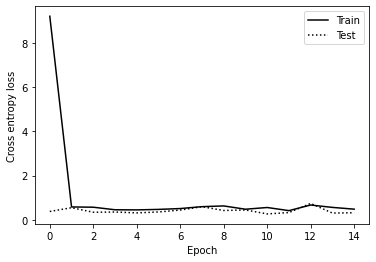

In [39]:
plt.plot(history.epoch,history.history['loss'], '-k', label='Train')
plt.plot(history.epoch,history.history['val_loss'], ':k', label='Test')
plt.legend()
plt.ylabel('Cross entropy loss')
plt.xlabel('Epoch');

In [40]:
model.evaluate(X_test,  Y_test_classes, verbose=2)

29/29 - 0s - loss: 0.3128 - accuracy: 0.9100


[0.3128296136856079, 0.9100000262260437]

In [41]:
X1 = np.array([dev_subset[band] for band in bands]).T
dev_predicted_sit = model.predict(X1)
dev_predicted_sit_class = np.argmax(dev_predicted_sit, axis=2).astype('float32').T
dev_predicted_sit_class[np.isnan(dev_subset[bands[0]])] = np.nan

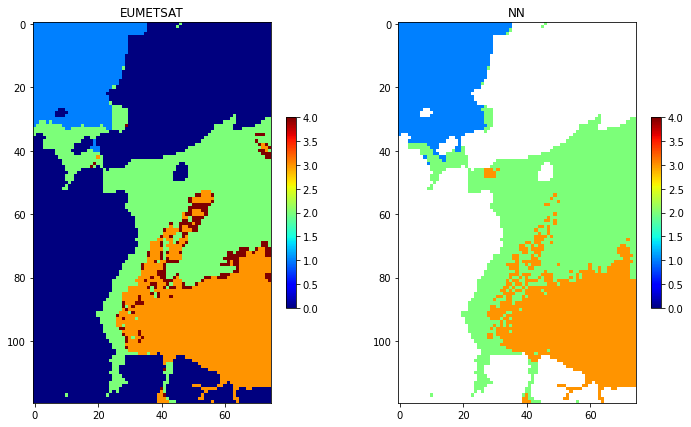

In [42]:
# plot maps of selected bands
fig, ax = plt.subplots(1,2, figsize=(12,7))
img = ax[0].imshow(dev_subset['sit'], cmap='jet', interpolation='nearest')
plt.colorbar(img, ax=ax[0], shrink=0.5)
ax[0].set_title('EUMETSAT')

img = ax[1].imshow(dev_predicted_sit_class + 1, cmap='jet', interpolation='nearest', clim=[0,4])
plt.colorbar(img, ax=ax[1], shrink=0.5)
ax[1].set_title('NN')


# plt.savefig('sit_amsr2_bands.png', dpi=150, pad_inches=0, bbox_inches='tight')
plt.show()

In [43]:
mask = (val_subset['sit'] > 0) * (val_subset['sit'] < 4)

# create 2D array of features
X_val = np.array([val_subset[band][mask] for band in bands]).T
# create 1D vector of targets
Y_val = val_subset['sit'][mask]
Y_val_classes = tf.one_hot(Y_val - 1, N_classes).numpy()

In [44]:
model.evaluate(X_val,  Y_val_classes, verbose=2)

75/75 - 0s - loss: 0.6267 - accuracy: 0.9003


[0.626679539680481, 0.9002514481544495]

In [45]:
X2 = np.array([val_subset[band] for band in bands]).T
val_predicted_sit = model.predict(X2)
val_predicted_sit_class = np.argmax(val_predicted_sit, axis=2).astype('float32').T
val_predicted_sit_class[np.isnan(val_subset[bands[0]])] = np.nan

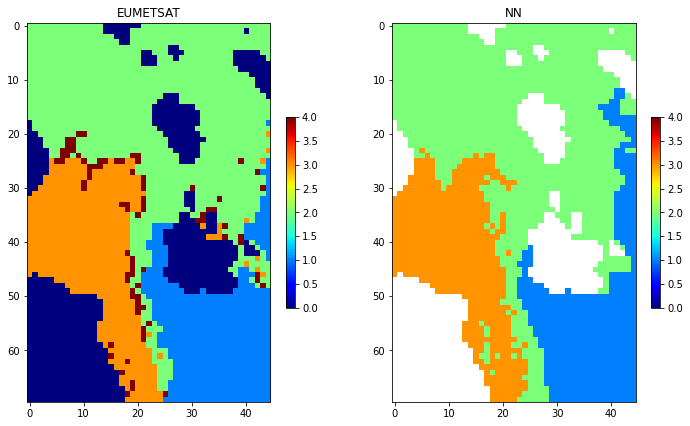

In [46]:
# plot maps of selected bands
fig, ax = plt.subplots(1,2, figsize=(12,7))
img = ax[0].imshow(val_subset['sit'], cmap='jet', interpolation='nearest')
plt.colorbar(img, ax=ax[0], shrink=0.5)
ax[0].set_title('EUMETSAT')

img = ax[1].imshow(val_predicted_sit_class + 1, cmap='jet', interpolation='nearest', clim=[0,4])
plt.colorbar(img, ax=ax[1], shrink=0.5)
ax[1].set_title('NN')


# plt.savefig('sit_amsr2_bands.png', dpi=150, pad_inches=0, bbox_inches='tight')
plt.show()

# Excersises

1. Select different features:
```python
# Select different features from the list 
bands = ['h06', 'v06', 'h07', 'v07', 'h10', 'v10', 'h18', 'v18', 'h23', 'v23', 'h36', 'v36', 'h89', 'v89']
```
2. Change number of layers/nodes in the net
```python
# tf.keras.layers.Dense(31, activation='relu'), # NOTE: Uncomment to use! 
```
3. Test different activation function:
```python
# Modify the parameter inside tf.keras.layers.Dense()
activation='sigmoid'
```
4. Add L2 regularization term: 
```python
# Modify the parameter inside tf.keras.layers.Dense()
kernel_regularizer=tf.keras.regularizers.l2(0.0001)
```


# Random Forest Classifier

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# create a Random Forest classifier with default options
clf = RandomForestClassifier(n_estimators=53)
# train the classifier
clf.fit(X_train, Y_train)
# test the trained classifier on independent data
Y_dev_pred = clf.predict(X_test)
# compute accuracy of the classifier
print(accuracy_score(Y_test, Y_dev_pred))

0.9466666666666667


In [74]:
# create an empty 2D array with sea ice type map
Y_dev_pred = clf.predict(X)
sit_dev_rf = np.zeros_like(dev_subset['sit'])
sit_dev_rf[mask_dev] = Y_dev_pred

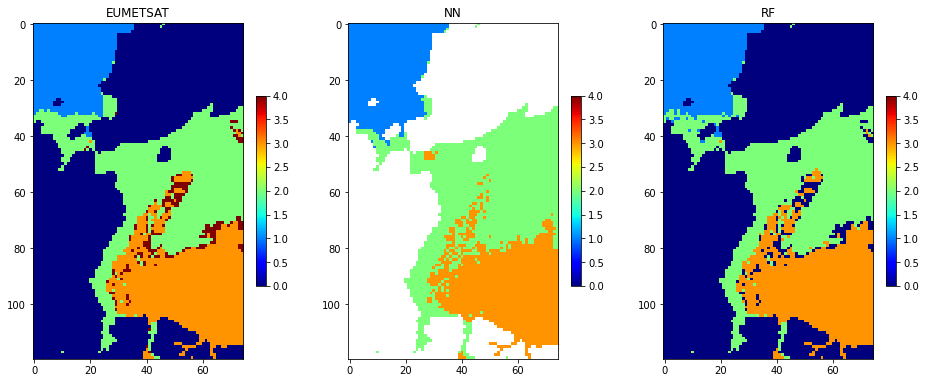

In [75]:
# plot maps of selected bands
fig, ax = plt.subplots(1,3, figsize=(16,7))
img = ax[0].imshow(dev_subset['sit'], cmap='jet', interpolation='nearest')
plt.colorbar(img, ax=ax[0], shrink=0.5)
ax[0].set_title('EUMETSAT')

img = ax[1].imshow(dev_predicted_sit_class + 1, cmap='jet', interpolation='nearest', clim=[0,4])
plt.colorbar(img, ax=ax[1], shrink=0.5)
ax[1].set_title('NN')

img = ax[2].imshow(sit_dev_rf, cmap='jet', interpolation='nearest', clim=[0,4])
plt.colorbar(img, ax=ax[2], shrink=0.5)
ax[2].set_title('RF')

plt.show()

In [76]:
Y_val_pred = clf.predict(X_val)
print(accuracy_score(Y_val_pred, Y_val))

0.8000838222967309


In [77]:
# create an empty 2D array with sea ice type map
sit_new = np.zeros_like(val_subset['sit'])
sit_new[mask_val] = Y_val_pred

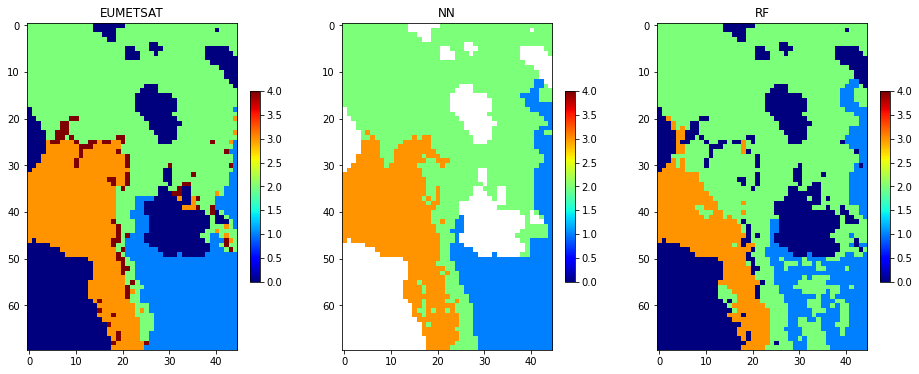

In [78]:
# plot maps of selected bands
fig, ax = plt.subplots(1, 3, figsize=(16,7))
img = ax[0].imshow(val_subset['sit'], cmap='jet', interpolation='nearest')
plt.colorbar(img, ax=ax[0], shrink=0.5)
ax[0].set_title('EUMETSAT')

img = ax[1].imshow(val_predicted_sit_class + 1, cmap='jet', interpolation='nearest', clim=[0,4])
plt.colorbar(img, ax=ax[1], shrink=0.5)
ax[1].set_title('NN')

img = ax[2].imshow(sit_new, cmap='jet', interpolation='nearest', clim=[0,4])
plt.colorbar(img, ax=ax[2], shrink=0.5)
ax[2].set_title('RF')

plt.show()